In [20]:
import pandas as pd
from get_milestones import main
from path import Path
import os
from collections import Counter
import time
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('./data/change_org_petitions_Amber_Heard_at_20211005-222550_limit_1000_offset_0_delay_ms_500.csv')
df_manual = pd.read_csv('./data/manual_petition_slugs.csv')

In [4]:
error_slugs = set()
for slug in tqdm(list(df['petition__slug']) + list(df_manual.slug)):
    if not isinstance(slug, str):
        continue
    args = type('obj', (object,), {'petition_slug': slug, 'delay_ms': 100})
    with Path('./data'):
        try:
            main(args)
        except Exception as e:
            print(slug, e)
            error_slugs.add(slug)

  0%|          | 0/295 [00:00<?, ?it/s]

File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing nothing!
File already exists, doing n

In [5]:
# first two are not relevant
# the second one does not have public milestones
error_slugs

{'donald-j-trump-free-rapper-ynw-melly-he-is-being-framed-by-police-facing-the-death-penalty-we-have-got-to-stop-the-state-of-florida-from-killing-2-innocent-men-blacklivesmatter-alllivesmatter-freeynwmelly-freeynwbortlen',
 'sheriff-tom-bosenko-california-state-governor-california-state-senate-u-s-attorney-generl-kamala-sheriff-tom-bosenko-california-state-governor-california-state-senate-u-s-attorney-general-k-request-the-fbi-investigate-the-disappearance-of-e'}

In [6]:
# merging everything into a single dataframe

In [7]:
l = os.listdir('./data')
fs = []
for filename in l:
    if not(filename.startswith('change_org_milestones_petition_slug_') and filename.endswith('.csv')):
        continue
    fs.append('./data/' + filename)

In [8]:
def read_set_slug(f):
    df = pd.read_csv(f)
    ff = os.path.basename(f)
    slug = ff[len('change_org_milestones_petition_slug_'):ff.index('_at_')]
    df['petition__slug'] = [slug] * len(df)
    return df

In [10]:
df = pd.concat([read_set_slug(f) for f in tqdm(fs)])
df = df.reset_index()

df_status = pd.read_csv('./data/all_petitions_status_manual.csv')
def get_status(slug):
    try:
        return df_status[df_status['slug'] == slug].iloc[0].status
    except:
        return 'irrelevant'
df['status_manual'] = [get_status(t) for t in df.petition__slug]
df = df[df['status_manual'] != 'irrelevant']

  0%|          | 0/305 [00:00<?, ?it/s]

In [9]:
df.to_csv(f"./data/all_petitions_milestones_{time.strftime('%Y%m%d-%H%M%S')}.csv", index=False)

# Optional: plotting all timelines

In [11]:
from matplotlib import pyplot as plt

In [12]:
df_ = df[df['__typename'] == 'MilestonePetitionUpdate'].copy()

In [13]:
df_['createdAt'] = pd.to_datetime(df_.createdAt)

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

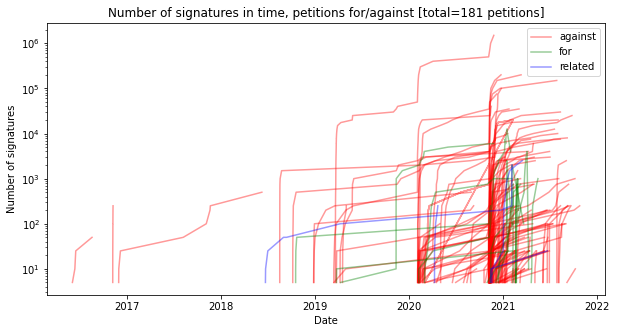

In [14]:
colors = {'for': 'green', 'against': 'red', 'related': 'blue'}
plt.figure(figsize=(10, 5))
plt.title('Number of signatures in time, petitions for/against [total=%d petitions]' % len(set(df_.petition__slug)))
for status, group_status in df_.groupby('status_manual'):
    i = 0
    for petition__slug, group in tqdm(group_status.groupby('petition__slug')):
        kwargs = {}
        if i == 0:
            kwargs['label'] = status
        plt.plot(group.createdAt, group.signatureCount, color=colors[status], alpha=0.4, **kwargs)
        i += 1
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Number of signatures')
plt.legend()
plt.savefig('./figures/petitions_signatures_in_time.png', bbox_inches='tight')
plt.show()

Timestamp('2021-11-12 11:30:29.403566')

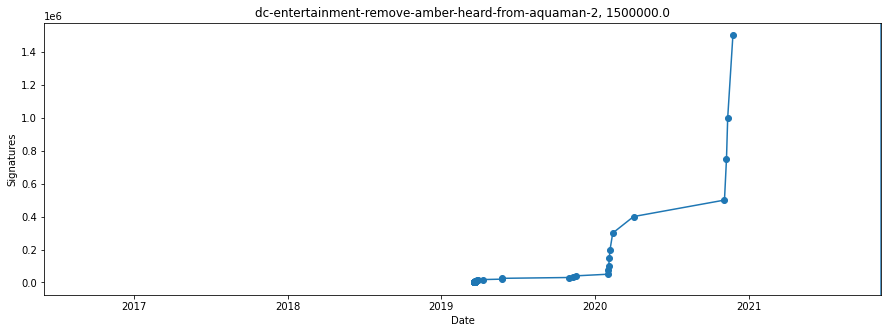

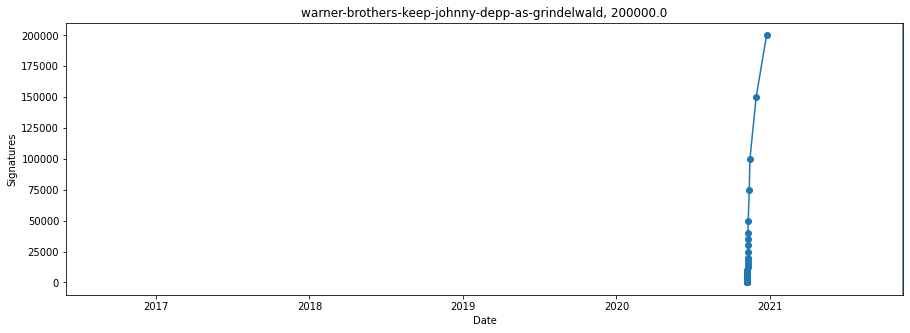

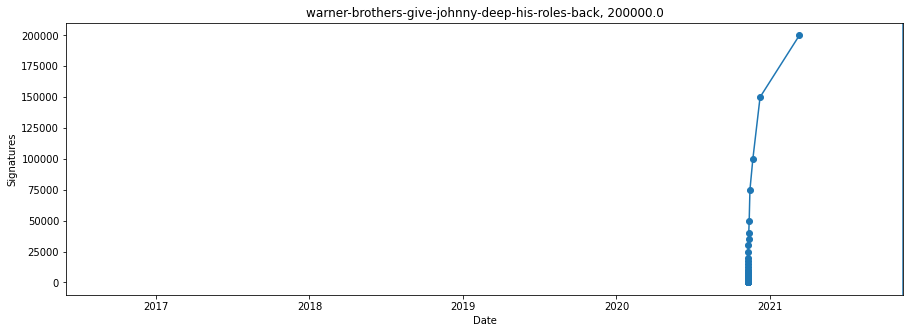

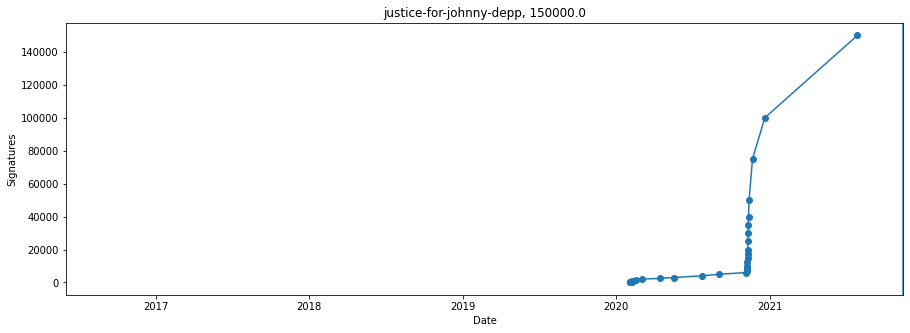

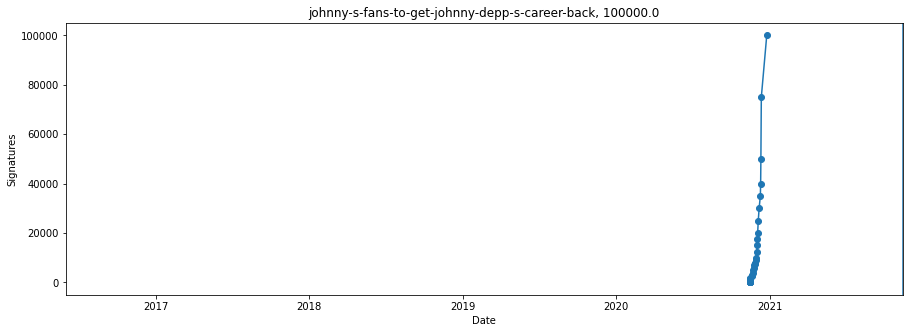

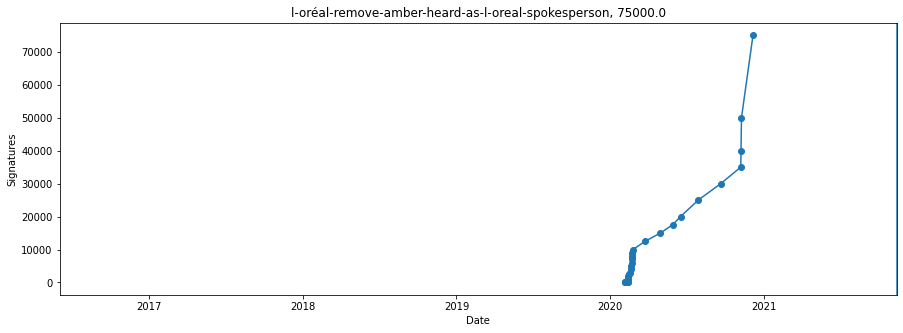

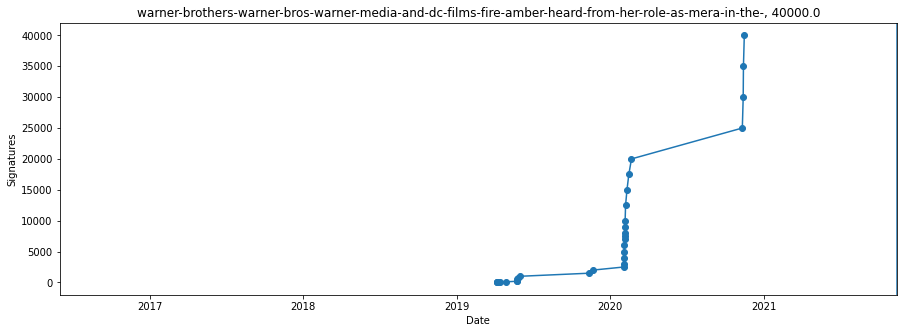

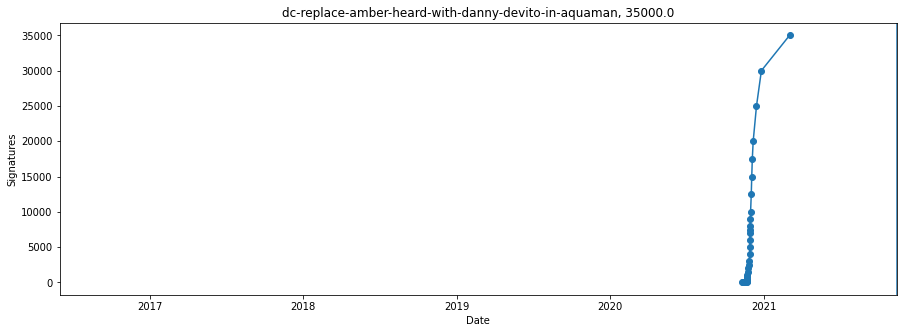

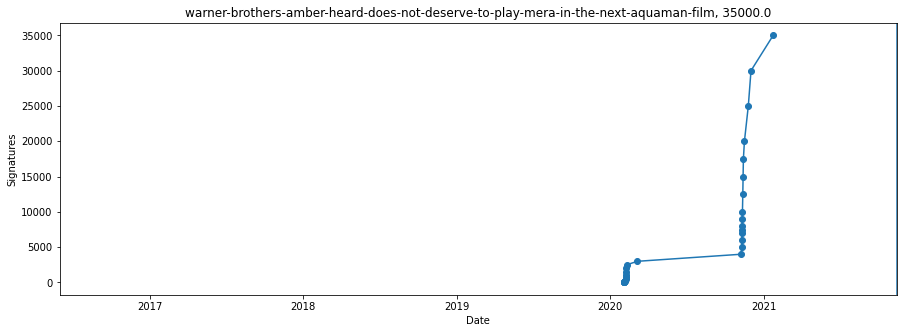

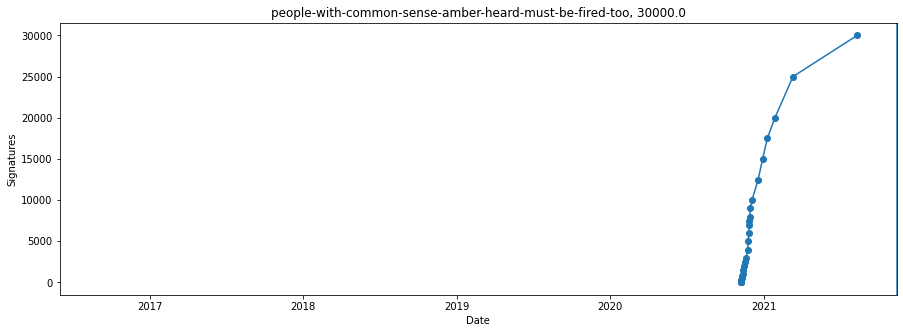

In [78]:
import datetime
maxCount = {slug: max(data.signatureCount) for slug, data in df_.groupby('petition__slug')}
df_count = pd.DataFrame(maxCount.items(),
                        columns=['slug', 'signatures'])\
               .sort_values('signatures', ascending=False)
groups = [[i] for i in range(10)]
for group in groups:
    plt.figure(figsize=(15, 5))
    for _, item in df_count.iloc[group].iterrows():

        plt.title(f"{item.slug[:100]}, {item.signatures}")
        data = df_[df_['petition__slug'] == item.slug]
        plt.xlabel('Date')
        # plt.yscale('log')
        plt.ylabel('Signatures')
        plt.plot(data.createdAt, data.signatureCount)
        plt.scatter(data.createdAt, data.signatureCount)
        plt.xlim(min(df_.createdAt), pd.to_datetime(datetime.datetime.now()))
        # plt.xlim(
        #     pd.to_datetime(datetime.datetime(2020, 10, 29)),
        #     pd.to_datetime(datetime.datetime(2020, 11, 15))
        # )
    plt.axvline(pd.to_datetime(datetime.datetime.now()))
    plt.show()